# Sentiment Classification for Movie Review Dataset (Korean)

본 핸즈온에서는 네이버 영화 리뷰에 대한 감정(0: 부정, 1: 긍정)을 요약한 네이버 영화 리뷰 데이터셋으로 AutoGluon 훈련을 수행합니다.

In [1]:
import os
import torch
import mxnet as mx
num_gpus = torch.cuda.device_count()

if num_gpus == 0:
    os.environ['AUTOGLUON_TEXT_TRAIN_WITHOUT_GPU'] = '1'

print(num_gpus)

1


In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
np.random.seed(123)

<br>

## 1. Data preparation and Training

https://github.com/e9t/nsmc/ 에 공개된 네이버 영화 리뷰 데이터셋을 다운로드합니다.
훈련 데이터는 총 15만건이며, 테스트 데이터는 총 5만건입니다.

In [3]:
save_path = 'ag-02-sentiment-classifcation-kor'
!rm -rf $save_path input

In [4]:
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt -P ./input/
!wget -nc https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt -P ./input/

--2022-08-29 10:23:42--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘./input/ratings_train.txt’

100%[======================================>] 14,628,807  --.-K/s   in 0.04s   

2022-08-29 10:23:42 (328 MB/s) - ‘./input/ratings_train.txt’ saved [14628807/14628807]

--2022-08-29 10:23:42--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [te

In [5]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('./input/ratings_train.txt', header=0, delimiter='\t')
test_df = pd.read_csv('./input/ratings_test.txt', header=0, delimiter='\t')
train_df = train_df[['document', 'label']]
test_df = test_df[['document', 'label']]

In [6]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(train_df)
test_data = TabularDataset(test_df)

subsample_size = 1000  # subsample data for faster demo, try setting this to larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
test_data = test_data.sample(n=subsample_size, random_state=0)
train_data.head(5)

,document,label
16269,가벼우면서도 보여줄건 다 보여주는 성실함.,1
140471,겁나재밌어...ㅋㅋ아는내용그대로나와도보게되긴함..시청률이떨어지고있지만 트로트의연인 ...,1
78683,젊은시절 이소룡의 광팬이 되어 개봉작마다 개봉 첫날에 영화보기 위해 줄서서 기다렸던...,1
2605,최악...감동도없고 ....대놓고범죄..ㅡㅡ말도안돼는영화,0
81156,어머니에게 감사드려요ㅜㅜ,1


간단한 전처리를 수행합니다. 특수 문자와 한글 외 문자들을 제거하고 중복값 및 결측값을 제외합니다.

In [7]:
def basic_preprocess(data):
    data.drop_duplicates(subset = ['document'], inplace=True)
    data['document'] = data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    #data['document'] = data['document'].str.replace("[\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]", " ") # 특수문자 제거만 사용
    data = data.dropna(how='any')
    return data

In [8]:
train_data = basic_preprocess(train_data)
test_data = basic_preprocess(test_data)

훈련 지정 시 좀 더 세부적인 하이퍼파라메터 설정이 필요하다면, 사전 정의된 preset을 사용하시면 편리합니다. TextPredictor는 사전 훈련된 BERT, RoBERT, ELECTRA가 내장되어 있으며, 한국어를 비롯한 다국어에 대한 훈련이 필요하면 `multi_cased_bert_base_fuse_late` preset을 사용하시면 됩니다.

In [9]:
from autogluon.text import TextPredictor, list_text_presets
list_text_presets()

['default',
 'medium_quality_faster_train',
 'high_quality',
 'best_quality',
 'multilingual']

In [10]:
list_text_presets(verbose=True)

{'default': {'model.hf_text.checkpoint_name': 'google/electra-base-discriminator'},
 'medium_quality_faster_train': {'model.hf_text.checkpoint_name': 'google/electra-small-discriminator',
  'optimization.learning_rate': 0.0004},
 'high_quality': {'model.hf_text.checkpoint_name': 'google/electra-base-discriminator'},
 'best_quality': {'model.hf_text.checkpoint_name': 'microsoft/deberta-v3-base',
  'env.per_gpu_batch_size': 2},
 'multilingual': {'model.hf_text.checkpoint_name': 'microsoft/mdeberta-v3-base',
  'optimization.top_k': 1,
  'env.precision': 'bf16',
  'env.per_gpu_batch_size': 4}}

### Integrated with HuggingFace's Transformers

AutoGluon Text는 2022년부터 Hugging Face의 Transformers와 통합되었습니다. 이는 Hugging Face의 model hub의 모델을 가져와서 파인튜닝할 수 있다는 의미로, Hugging Face의 API 용법을 숙지할 필요가 없기 때문에 Low-code ML 구현에 이상적합니다.

In [11]:
from autogluon.text import TextPredictor

predictor = TextPredictor(label='label', eval_metric='acc', path=save_path)
predictor.set_verbosity(2)

predictor.fit(
    train_data,
    hyperparameters={
      'model.hf_text.checkpoint_name': 'daekeun-ml/koelectra-small-v3-nsmc',
      'optimization.max_epochs': 2
    }
)

Global seed set to 123


Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/521k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/914 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/54.0M [00:00<?, ?B/s]

Auto select gpus: [0]
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                         | Params
-------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 14.1 M
1 | validation_metric | Accuracy                     | 0     
2 | loss_func         | CrossEntropyLoss             | 0     
-------------------------------------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    Total params
28.113    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 3: 'val_acc' reached 0.92000 (best 0.92000), saving model to '/home/ec2-user/SageMaker/autogluon-on-aws/2.nlp/ag-02-sentiment-classifcation-kor/epoch=0-step=3.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 7: 'val_acc' reached 0.93500 (best 0.93500), saving model to '/home/ec2-user/SageMaker/autogluon-on-aws/2.nlp/ag-02-sentiment-classifcation-kor/epoch=0-step=7.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 10: 'val_acc' reached 0.93000 (best 0.93500), saving model to '/home/ec2-user/SageMaker/autogluon-on-aws/2.nlp/ag-02-sentiment-classifcation-kor/epoch=1-step=10.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 14: 'val_acc' reached 0.93000 (best 0.93500), saving model to '/home/ec2-user/SageMaker/autogluon-on-aws/2.nlp/ag-02-sentiment-classifcation-kor/epoch=1-step=14.ckpt' as top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

<br>

## 2. Evaluation and Prediction

### Evaluation

`predictor.evaluation()`를 사용하여 평가를 쉽게 수행할 수 있으며, F1 score 등의 추가 metric도 지정 가능합니다.

In [12]:
if num_gpus > 0:
    test_score = predictor.evaluate(test_data, metrics=['acc', 'f1'])
    print(test_score)    

Predicting: 0it [00:00, ?it/s]

{'acc': 0.8868868868868869, 'f1': 0.884102564102564}


### Prediction
`predictor.predict()`으로 예측을 수행할 수 있습니다.

In [13]:
sentence1 = "이 영화 너무너무 재미있어요. 인생 최고의 영화입니다. 최고!"
sentence2 = "평점 1점도 아깝습니다..비추"
predictions = predictor.predict({'document': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Sentiment":', predictions[0])
print('"Sentence":', sentence2, '"Predicted Sentiment":', predictions[1])

Predicting: 0it [00:00, ?it/s]

"Sentence": 이 영화 너무너무 재미있어요. 인생 최고의 영화입니다. 최고! "Predicted Sentiment": 1
"Sentence": 평점 1점도 아깝습니다..비추 "Predicted Sentiment": 0


### Extract Embeddings
훈련된 predictor를 사용하여 임베딩 벡터에 매핑하는 임베딩을 추출할 수도 있습니다.

In [14]:
embeddings = predictor.extract_embedding(test_data)
print(embeddings)

Predicting: 0it [00:00, ?it/s]

[[ 0.84613824 -0.0617782   0.49753773 ... -0.10038111  0.6010558
  -0.83211917]
 [-0.2658142  -0.06882589 -0.09763969 ... -0.10286628  0.33666134
   0.16731662]
 [ 0.0561719  -0.26758084  0.03778086 ...  0.02988471 -0.33176646
   0.42773318]
 ...
 [-0.19822933  0.21227556  0.06556442 ... -0.11700189  0.9228656
  -0.17247312]
 [-0.34605423  0.2459117   0.10616192 ... -0.11148816  1.0476282
  -0.26367357]
 [ 0.06941266  0.1493763  -0.43007994 ... -0.02132886 -0.39746076
   0.34852082]]


TSNE를 사용하여 추출된 임베딩을 시각화합니다. 성능 향상을 위해서는 다국어 모델보다는 한국어 전용 모델로 훈련하는 것이 더 유리합니다.

Predicting: 0it [00:00, ?it/s]

[[ 0.84613824 -0.0617782   0.49753773 ... -0.10038111  0.6010558
  -0.83211917]
 [-0.2658142  -0.06882589 -0.09763969 ... -0.10286628  0.33666134
   0.16731662]
 [ 0.0561719  -0.26758084  0.03778086 ...  0.02988471 -0.33176646
   0.42773318]
 ...
 [-0.19822933  0.21227556  0.06556442 ... -0.11700189  0.9228656
  -0.17247312]
 [-0.34605423  0.2459117   0.10616192 ... -0.11148816  1.0476282
  -0.26367357]
 [ 0.06941266  0.1493763  -0.43007994 ... -0.02132886 -0.39746076
   0.34852082]]


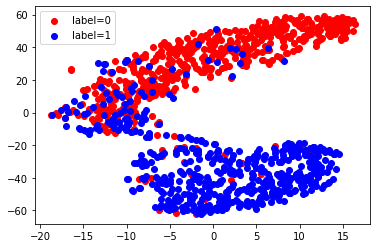

In [15]:
if num_gpus > 0:
    from sklearn.manifold import TSNE
    embeddings = predictor.extract_embedding(test_data)
    print(embeddings)

    X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
    for val, color in [(0, 'red'), (1, 'blue')]:
        idx = (test_data['label'].to_numpy() == val).nonzero()
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
    plt.legend(loc='best')    